### Code to plot 90 th and 10th percentiles of vertical velocity
#### author:  Claudia Acquistapace
#### date: 09/12/2021
#### goal: plot the 90th and 10th percentiles of vertical velocity

In [13]:

# importing necessary libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
import pandas as pd
import netCDF4 as nc4
string_out = '20200202_20200203'
sst_flag_file = "20200202_20200203_sst_flag10_90_perc.nc"
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)
x_max_cb = 2000.
x_min_cb = 400.


In [4]:
# reading SST flag for tsg data
path_sst_flag = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/"
sst_flag = xr.open_dataset(path_sst_flag+sst_flag_file)
sst_flag

<xarray.Dataset>
Dimensions:   (time: 2880)
Coordinates:
  * time      (time) datetime64[ns] 2020-02-02T00:00:55.000003328 ... 2020-02...
Data variables:
    sst_tsg   (time) float64 ...
    flag_tsg  (time) float64 ...
Attributes:
    created_by:  Claudia Acquistapace
    created_on:  2021-12-09 10:53:37.357519
    comment:     sst flag

In [5]:

# read wind lidar data
path_wind_lidar = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/data_wind_lidar/"
wind_lidar_file = "wind_lidar_eurec4a.nc"
path_fig = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/\
SST_impact_work/plots/"
wind_lidar = xr.open_dataset(path_wind_lidar+wind_lidar_file)

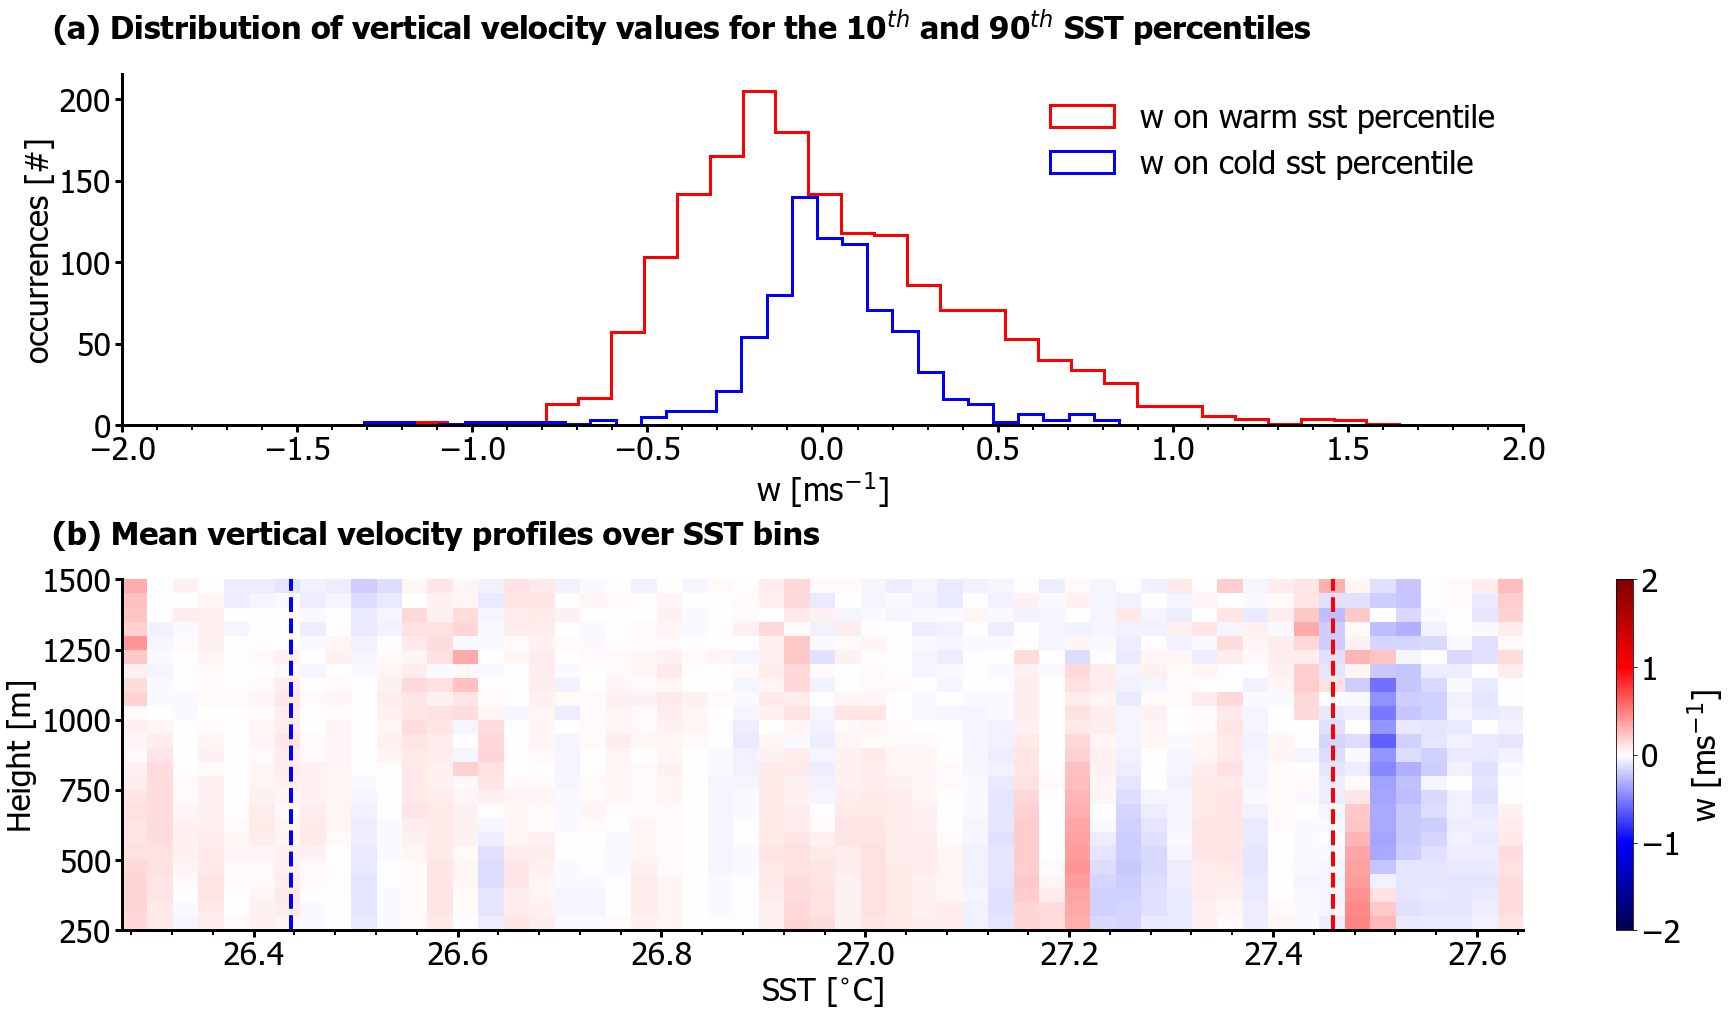

In [28]:


# selecting time interval to extract from wind lidar dataset
wind_lidar_slice = wind_lidar.sel(time=slice(t_start, t_end))

# interpolating sst data at 1 s resolution to the 10 s res of the wind lidar
sst_data_interp = sst_flag.interp(time=wind_lidar_slice['time'].values)

# merging the interpolated dataset and the wind lidar dataset
data_merged = xr.merge([wind_lidar_slice, sst_data_interp])

# selecting data in the lowest 300 m and from 500 to 800 m
data_surf = data_merged.sel(height=slice(0., 300.))
data_cloud = data_merged.sel(height=slice(500., 1000.))

# calculating mean over height for both datasets
data_surf_mean = data_surf.mean(dim='height', skipna=True)
w_surf = data_surf_mean['w'].values
cb_surf = data_surf_mean['cb'].values
flag = data_surf_mean['flag_tsg'].values


# selecting cold and warm dataset indeces
i_cold = np.where(flag == 1)
i_warm = np.where(flag == 2)

# reading wind and cloud base
w_cold = w_surf[i_cold]
w_warm = w_surf[i_warm]
cb_cold = cb_surf[i_cold]
cb_warm = cb_surf[i_warm]

dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# read w binned values over SST to prepare the composite plot
path_SST_binned = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/'
filename = 'arthus_binned_sst.nc'
arthus_data = xr.open_dataset(path_SST_binned+filename)
W_data = arthus_data['VW'].values
sst_arr = arthus_data['sst'].values
height = arthus_data['height'].values


# building SST binned array
sst_tsg = sst_flag['sst_tsg'].values
SST_min = np.nanmin(sst_tsg)
SST_max = np.nanmax(sst_tsg)
SST_binned_arr = np.arange(SST_min, SST_max, step=0.025)


# calculate label marks for bins
sst_bin_label = []
for ind in range(len(SST_binned_arr)-1):
    sst_bin_label.append(round((SST_binned_arr[ind]+SST_binned_arr[ind+1])/2,2))
    
ten_per_value = 26.4363 
ninth_per_value = 27.4587


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(2,1, figsize=(24,14), constrained_layout=True)

# setting dates formatter 
#[a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) for a in axs[:].flatten()]
matplotlib.rc('xtick', labelsize=32)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=32)  # sets dimension of ticks in the plots
grid            = True

#axs[0].plot(time_mrr, profile_mrr, color='white')
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].get_xaxis().tick_bottom()
axs[0].get_yaxis().tick_left()
axs[0].spines["bottom"].set_linewidth(2)
axs[0].spines["left"].set_linewidth(2)
axs[0].tick_params(which='minor', length=7, width=3)
axs[0].tick_params(which='major', length=7, width=3)
axs[0].hist(w_warm, bins=30, color='red', label='w on warm sst percentile', histtype='step', lw=3)
axs[0].hist(w_cold, bins=30, color='blue', label='w on cold sst percentile', histtype='step', lw=3)
axs[0].legend(frameon=False, fontsize=fontSizeX)
axs[0].set_xlim([-2.,2.])
axs[0].set_xlabel("w [ms$^{-1}$]", fontsize=fontSizeX)
axs[0].set_ylabel("occurrences [#]", fontsize=fontSizeY)


axs[1].set_ylim(250.,1500.)

mesh = axs[1].pcolormesh(sst_arr, height, W_data.T, cmap='seismic', vmin=-2., vmax=2.)
cbar = fig.colorbar(mesh, ax=axs[1])
cbar.set_label(label='w [ms$^{-1}$]',  size=fontSizeX)
axs[1].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)
axs[1].axvline(x=ten_per_value, color='blue', linestyle='--', linewidth=4)
axs[1].axvline(x=ninth_per_value, color='red', linestyle='--', linewidth=4)

for ax, l in zip(axs[:].flatten(), ['(a) Distribution of vertical velocity values for the 10$^{th}$ and 90$^{th}$ SST percentiles ',  '(b) Mean vertical velocity profiles over SST bins ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)


fig.savefig(path_out_plots+'w_histogram_10_90_percentiles.png', format='png')

In [19]:
sst_flag

<xarray.Dataset>
Dimensions:   (time: 2880)
Coordinates:
  * time      (time) datetime64[ns] 2020-02-02T00:00:55.000003328 ... 2020-02...
Data variables:
    sst_tsg   (time) float64 27.66 27.66 27.66 27.65 ... 26.97 26.97 26.97 26.98
    flag_tsg  (time) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Attributes:
    created_by:  Claudia Acquistapace
    created_on:  2021-12-09 10:53:37.357519
    comment:     sst flag